In [24]:
import pandas as pd
import pickle 
import os
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd
import ast
import torch

In [25]:
station_i = 20
earthquake_data_i = "2"
data_path = "/data2/linhang_data/Earthquake_data/data/demo/"
start_year = 2020
end_year = 2023

#日本
minlat = 35
maxlat = 37
minlon = 138
maxlon = 141

space_size = 0.5

lat_step, lon_step = 0.1, 0.1
topk = 100
distance_threshold = 100

In [26]:
def parse_str_list(cell):
    try:
        return ast.literal_eval(cell)
    except (ValueError, SyntaxError):
        return cell

In [22]:
gnss_data = pd.read_csv(data_path+"gnss_data.csv", index_col=0, parse_dates=True).map(parse_str_list)
earthquake_data = pd.read_csv(data_path+"earthquake_data.csv", index_col=0, parse_dates=True)
energy_data = pd.read_csv(data_path+"energy_data.csv", index_col=0, parse_dates=True)
station_dict_use = pickle.load(open(data_path+"station_dict_use.pkl", "rb"))
earthquake_dict = pickle.load(open(data_path+"/grid_data/grid_id_map.pkl", "rb"))

In [29]:
dtw_aij = pickle.load(open(data_path+"adjacency_matrix.pkl", "rb"))
st_aij = pd.read_csv(data_path+"station_adjacency_matrix.csv", index_col=0)
ea_aij = pd.read_csv(data_path+"es_adjacency_matrix.csv", index_col=0)

In [6]:
def get_gnss_i(series, index):
    #[n, e, u, vectors]
    return series.apply(lambda x: x[index] if isinstance(x, list) and len(x) > index else None)

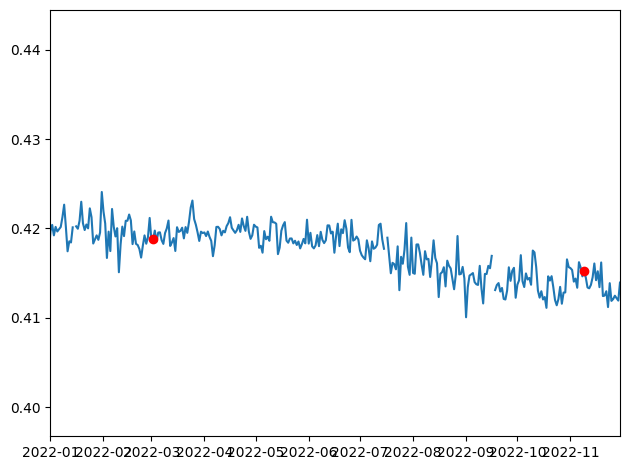

In [7]:

plt.plot(gnss_data.index,get_gnss_i(gnss_data[gnss_data.columns[station_i]],0), label='GNSS')
earthquake_happen_mask = earthquake_data[earthquake_data_i]>1
plt.plot(earthquake_data[earthquake_happen_mask].index,get_gnss_i(gnss_data[gnss_data.columns[station_i]],0)[earthquake_happen_mask], 'ro', label='Earthquake')
plt.xlim(datetime(2022,1,1), datetime(2022, 11, 30))
plt.tight_layout()

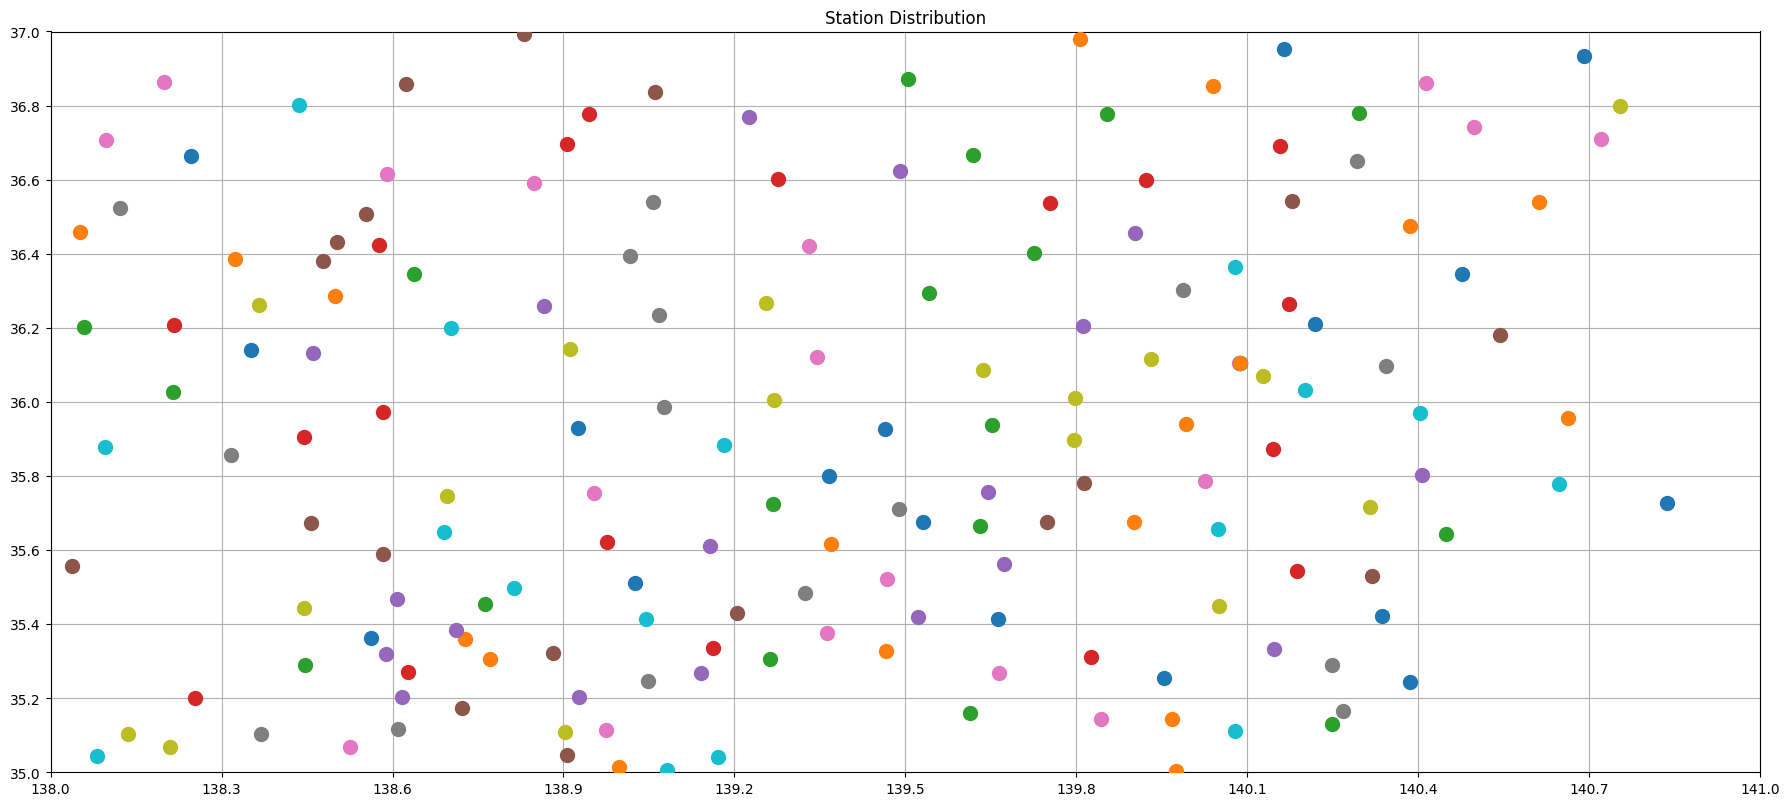

In [8]:
plt.figure(figsize=(18, 8))

# 绘制站点分布
for station_id in station_dict_use.keys():
    station_lat, station_lon = station_dict_use[station_id]
    station_lat = float(station_lat)
    station_lon = float(station_lon)
    plt.scatter(station_lon, station_lat, s=100, zorder=5, label=station_id)

# # 设置 x 轴和 y 轴的刻度
plt.xticks(np.around(np.linspace(minlon, maxlon, 2*int(space_size*10)+1), 2))  # 经度刻度
plt.yticks(np.around(np.linspace(minlat, maxlat, 2*int(space_size*10)+1), 2))  # 纬度刻度
#设置 x 轴和 y 轴的范围
plt.xlim(minlon, maxlon)
plt.ylim(minlat, maxlat)

# 添加网格
plt.grid(True)
# 调整布局
plt.tight_layout()
# 设置标题
plt.title('Station Distribution')
# 显示图表
plt.show()

In [9]:
lat_bins = np.around(np.linspace(minlat, maxlat, int((maxlat-minlat)/lat_step+1)), 2)
lon_bins = np.around(np.linspace(minlon, maxlon, int((maxlon-minlon)/lon_step+1)), 2)
grid_counts = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
grid_ids = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

for i, lat in enumerate(lat_bins[:-1]):
    for j, lon in enumerate(lon_bins[:-1]):
        lat = np.around(lat, 2)
        lon = np.around(lon, 2)
        file_path = os.path.join(data_path+"grid_data", f'grid_{lat}_{lon}.csv')
        if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
            try:
                df = pd.read_csv(file_path)
                grid_ids[i, j] = df['Location_id'][0]
                grid_counts[i, j] = len(df)
            except pd.errors.EmptyDataError:
                grid_counts[i, j] = 0
        else:
            grid_counts[i, j] = 0

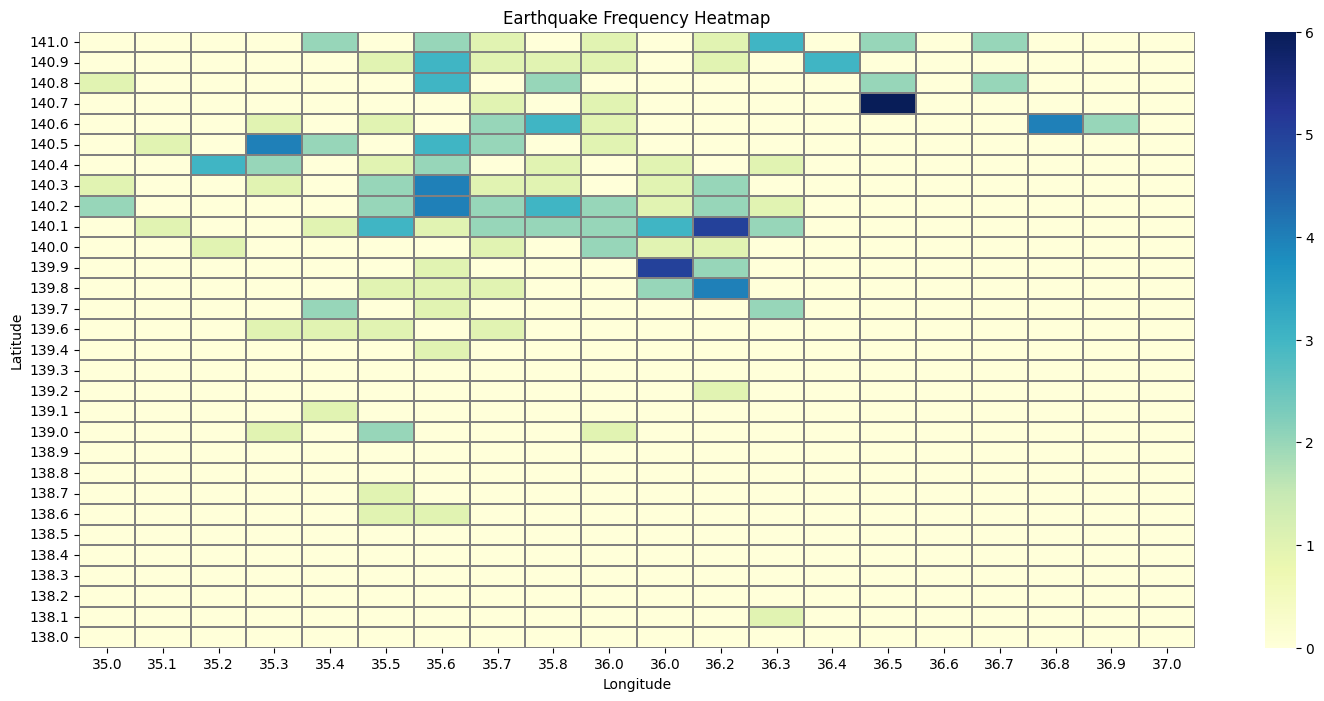

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
lat_bins = np.around(np.linspace(minlat, maxlat, int((maxlat-minlat)/lat_step)), 2)
lon_bins = np.around(np.linspace(minlon, maxlon, int((maxlon-minlon)/lon_step)), 2)
plt.figure(figsize=(18, 8))
sns.heatmap(grid_counts.T, cmap="YlGnBu", xticklabels=np.around(lat_bins, 1), 
            yticklabels=np.around(lon_bins, 1), linecolor='grey', linewidths=0.01)

plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquake Frequency Heatmap')
plt.show()

In [13]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

def fill_nan_with_interpolation(data):
    """
    对数据中的nan进行插值填充，使用矢量化操作进行优化。
    """
    # 创建数据的副本，避免修改原始数据
    data_filled = data.copy()

    # 处理每个维度上的NaN，避免双重循环
    for i in range(data_filled.shape[2]):  # 处理每个维度
        # 沿着第一个维度（行）对所有列应用插值函数
        def interpolate_row(row):
            mask = ~np.isnan(row)
            if np.sum(mask) > 1:
                # 创建插值函数
                interp_func = interp1d(np.where(mask)[0], row[mask], kind='linear', fill_value="extrapolate")
                return interp_func(np.arange(len(row)))
            return row  # 如果不能插值，则原样返回

        # 使用 np.apply_along_axis 对每一行（window_size维度）应用插值操作
        data_filled[:, :, i] = np.apply_along_axis(interpolate_row, axis=1, arr=data_filled[:, :, i])

    return data_filled


def convert_to_fixed_length_array(data, length=4):
    return [np.array(x[:length] if isinstance(x, list) else [np.nan]*length) for x in data]


In [14]:
def generate_time_bins(start_date, end_date, freq = 14):
    """
    高效批量生成从第一天开始的以2周为间隔的时间窗口。
    
    参数:
        start_date (str): 开始日期，格式 'YYYY-MM-DD'，例如 '2001-01-01'。
        end_date (str): 结束日期，格式 'YYYY-MM-DD'，例如 '2005-12-30'。
    
    返回:
        pd.DatetimeIndex: 以2周为间隔的时间窗口序列。
    """
    # 将输入的日期字符串转换为 Timestamp
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)

    total_days = (end_date - start_date).days
    num_intervals = total_days // freq

    time_bins = pd.DatetimeIndex([start_date + pd.Timedelta(days=14 * i) for i in range(num_intervals + 2)])

    return time_bins

In [15]:
import numpy as np
import pandas as pd

def calculate_energy_in_time_window(data,freq=14):
    """
    计算在指定时间窗口内的能量。
    
    参数:
        data (pd.DataFrame): 包含站点数据的DataFrame，行名为日期，列名为站点名。
    
    输出:
        返回每个站点在每个时间窗口内的对数能量结果DataFrame。
    """
    # 自动获取开始和结束日期
    start_date = data.index.min()
    end_date = data.index.max()
    print(start_date, end_date)

    time_bins = generate_time_bins(start_date, end_date, freq=freq)

    data = data.copy()
    data['Time_bin'] = pd.cut(data.index, bins=time_bins, right=True)

    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data[numeric_cols] = data[numeric_cols].where(data[numeric_cols] > 0).dropna(how='all')

    grouped = data.groupby('Time_bin', observed=False).sum()
    grouped_energy = 10 ** (1.5 * grouped)

    log_energy = (1 / 1.5) * np.log10(grouped_energy.replace(0, np.nan))

    log_energy_filled = log_energy.fillna(0)

    log_energy_filled.index = log_energy_filled.index.categories.left.strftime('%Y-%m-%d')

    return log_energy_filled

In [16]:
def find_first_earthquake(earthquake_catalog, threshold):
    """
    优化后的版本，返回一个 (500, 1) 的向量，表示每个站点的第一个大于阈值的地震发生的天数（行数）。

    参数:
    - earthquake_catalog (pd.DataFrame): 地震目录，每个值为地震震级，行名为日期。
    - threshold (float): 震级阈值，筛选出大于此阈值的地震。

    返回:
    - result_vector (np.ndarray): 返回 (500, 1) 的向量，每个值表示第一个超过阈值的地震发生的行数（天数）。
    """
    earthquake_data = earthquake_catalog.to_numpy()

    above_threshold = earthquake_data > threshold

    result_vector = np.zeros((earthquake_data.shape[1], 1))

    first_event_indices = np.argmax(above_threshold, axis=0)

    has_event = above_threshold.any(axis=0)
    
    result_vector[has_event, 0] = first_event_indices[has_event] + 1

    return result_vector

In [1]:
def generate_masks(es_geo_matrix, es_sem_matrix, gnss_geo_matrix, num_nodes, gnss_station_num, far_mask_delta, dtw_delta):
    # Generate geo_mask
    es_geo_matrix = es_geo_matrix.T
    geo_mask = torch.zeros(num_nodes, num_nodes)
    geo_mask[es_geo_matrix >= far_mask_delta] = 1
    es_geo_mask = geo_mask.bool()
    
    # Generate sem_mask
    sem_mask = torch.ones(num_nodes, num_nodes)
    sem_mask_indices = es_sem_matrix.argsort(axis=1)[:, :dtw_delta]
    for i in range(sem_mask.shape[0]):
        sem_mask[i][sem_mask_indices[i]] = 0
    es_sem_mask = sem_mask.bool()
    
    # Generate gnss_geo_mask
    gnss_geo_matrix = gnss_geo_matrix.T
    gnss_geo_mask = torch.zeros(gnss_station_num, gnss_station_num)
    gnss_geo_mask[gnss_geo_matrix >= far_mask_delta] = 1
    gnss_geo_mask = gnss_geo_mask.bool()
    
    return es_geo_mask, es_sem_mask, gnss_geo_mask

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset

class EarthquakeGNSSDataset(Dataset):
    def __init__(self, earthquake_data, gnss_data, es_geo_matrix, es_sem_matrix, gnss_geo_matrix, window_size=14, forecast_horizon=14, earthquake_threshold=4.0, far_mask_delta=100, dtw_delta=100):
        self.earthquake_data = earthquake_data
        self.gnss_data = gnss_data
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        self.earthquake_threshold = earthquake_threshold
        self.length = len(earthquake_data) - window_size - forecast_horizon + 1
        self.es_geo_matrix = es_geo_matrix
        self.es_sem_matrix = es_sem_matrix
        self.gnss_geo_matrix = gnss_geo_matrix
        self.es_geo_mask, self.es_sem_mask, self.gnss_geo_mask = generate_masks(es_geo_matrix, es_sem_matrix, gnss_geo_matrix, len(earthquake_data.columns), len(gnss_data.columns), far_mask_delta, dtw_delta)
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Get historical and future earthquake data
        earthquake_data_history = self.earthquake_data.iloc[idx:idx + self.window_size]
        earthquake_data_future = self.earthquake_data.iloc[idx + self.window_size:idx + self.window_size + self.forecast_horizon]

        # Calculate log energy history and future
        log_energy_history = np.array(calculate_energy_in_time_window(earthquake_data_history)).T
        log_energy_future = np.array(calculate_energy_in_time_window(earthquake_data_future)).T

        # Get the future earthquake data day threshold
        earthquake_data_future_day = find_first_earthquake(earthquake_data_future, self.earthquake_threshold)

        # Get the GNSS data history and process it
        gnss_data_history = self.gnss_data.iloc[idx:idx + self.window_size].values
        gnss_data_history = np.array([convert_to_fixed_length_array(row) for row in gnss_data_history.T])
        gnss_data_history = fill_nan_with_interpolation(gnss_data_history)

        # Convert data to tensors
        log_energy_history = torch.tensor(log_energy_history, dtype=torch.float32).permute(1, 0).unsqueeze(-1)
        log_energy_future = torch.tensor(log_energy_future, dtype=torch.float32)
        gnss_data_history = torch.tensor(gnss_data_history, dtype=torch.float32).permute(1, 0, 2)
        earthquake_data_future_day = torch.tensor(earthquake_data_future_day, dtype=torch.float32)

        return {
            'log_energy_history': log_energy_history,
            'gnss_data_history': gnss_data_history,
            'log_energy_future': log_energy_future,
            'earthquake_data_future_day': earthquake_data_future_day,
            'es_geo_mask': self.es_geo_mask,
            'es_sem_mask': self.es_sem_mask,
            'gnss_geo_mask': self.gnss_geo_mask
        }



In [106]:
from torch.utils.data import DataLoader

# Example usage
window_size = 14 * 102
forecast_horizon = 14

dataset = EarthquakeGNSSDataset(earthquake_data, gnss_data, window_size, forecast_horizon)
# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate through the DataLoader
for batch in dataloader:
    log_energy_history = batch['log_energy_history']
    gnss_data_history = batch['gnss_data_history']
    log_energy_future = batch['log_energy_future']
    earthquake_data_future_day = batch['earthquake_data_future_day']
    print(log_energy_history.shape, gnss_data_history.shape, log_energy_future.shape, earthquake_data_future_day.shape)
    # Further processing or training can be done here

2020-01-08 00:00:00 2023-12-05 00:00:00
2023-12-06 00:00:00 2023-12-19 00:00:00
2020-01-10 00:00:00 2023-12-07 00:00:00
2023-12-08 00:00:00 2023-12-21 00:00:00
2020-01-17 00:00:00 2023-12-14 00:00:00
2023-12-15 00:00:00 2023-12-28 00:00:00
2020-01-09 00:00:00 2023-12-06 00:00:00
2023-12-07 00:00:00 2023-12-20 00:00:00
2020-01-18 00:00:00 2023-12-15 00:00:00
2023-12-16 00:00:00 2023-12-29 00:00:00
2020-01-12 00:00:00 2023-12-09 00:00:00
2023-12-10 00:00:00 2023-12-23 00:00:00
2020-01-07 00:00:00 2023-12-04 00:00:00
2023-12-05 00:00:00 2023-12-18 00:00:00
2020-01-16 00:00:00 2023-12-13 00:00:00
2023-12-14 00:00:00 2023-12-27 00:00:00
2020-01-11 00:00:00 2023-12-08 00:00:00
2023-12-09 00:00:00 2023-12-22 00:00:00
2020-01-05 00:00:00 2023-12-02 00:00:00
2023-12-03 00:00:00 2023-12-16 00:00:00
2020-01-20 00:00:00 2023-12-17 00:00:00
2023-12-18 00:00:00 2023-12-31 00:00:00
2020-01-06 00:00:00 2023-12-03 00:00:00
2023-12-04 00:00:00 2023-12-17 00:00:00
2020-01-19 00:00:00 2023-12-16 00:00:00
